In [1]:
# Imports
import numpy as np
import altair as alt
import pydot
from IPython.display import display, SVG, clear_output, HTML
import matplotlib.pyplot as plt

from pydrake.all import (
    AddMultibodyPlantSceneGraph, AngleAxis, BasicVector, GenerateHtml,
    DiagramBuilder, FindResourceOrThrow, Integrator, JacobianWrtVariable, 
    LeafSystem, MeshcatVisualizerCpp, MultibodyPlant, MultibodyPositionToGeometryPose, Parser,
    PiecewisePose, PiecewisePolynomial, Quaternion, RigidTransform, 
    RollPitchYaw, RotationMatrix, SceneGraph, Simulator, TrajectorySource, MeshcatVisualizerParams,
    InverseDynamicsController, LogVectorOutput, InverseKinematics, Solve
)
from pydrake.examples.manipulation_station import ManipulationStation

from manipulation import running_as_notebook
from manipulation.meshcat_cpp_utils import (
    StartMeshcat, MeshcatJointSlidersThatPublish)
from manipulation.scenarios import AddMultibodyTriad, SetColor

In [2]:
# Start the visualizer.
meshcat = StartMeshcat()

In [4]:
# Adding a table

builder = DiagramBuilder()

# urdf_path = './diva_teleop_boxy.urdf'
# urdf_path = './urdfs/sample_designs/divar3v7303.urdf'
urdf_path = './divar3v-reference.urdf'
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
model = Parser(plant, scene_graph).AddModelFromFile(urdf_path, 'diva_robot')


# Transform for the table location
X_R = RigidTransform(RotationMatrix.MakeYRotation(-np.pi/2), np.array([-0.1, 0.5, 1]))
# For shoulder re-orientation use below
# X_R = RigidTransform(RotationMatrix(RollPitchYaw([0.8, -0.8, 0])), np.array([-0.1, 0.5, 1]))
Parser(plant, scene_graph).AddModelFromFile('./urdfs/table/extra_heavy_duty_table_modified.sdf','table')

plant.WeldFrames(plant.world_frame(), plant.get_body(plant.GetBodyIndices(model)[0]).body_frame(), X_R)
# plant.WeldFrames(plant.world_frame(), plant.get_body(plant.GetBodyIndices(table)[0]).body_frame(), X_T)
plant.Finalize()

# Delete any previous models
meshcat.Delete()
meshcat.DeleteAddedControls()

visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)

diagram = builder.Build()
context = diagram.CreateDefaultContext()
plant.SetPositions(plant.GetMyContextFromRoot(context),model,
                      [0.21, -1.03, 1.28, -1.1, 2.8, 1.5, 0])
# To actually see the context, publish diagram
diagram.Publish(context)

In [ ]:
def gripper_forward_kinematics_example():
    builder = DiagramBuilder()

    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
    
    urdf_path = './urdfs/sample_designs/divar3v53687.urdf'
    model = Parser(plant, scene_graph).AddModelFromFile(urdf_path, 'diva_robot')
    
#     model = Parser(plant, scene_graph).AddModelFromFile('./diva_teleop_boxy.urdf', 'diva_robot')
    # Transform for the robot root
    X_R = RigidTransform(RotationMatrix.MakeYRotation(-np.pi/2), np.array([-0.1, 0.5, 1]))
    # Robot root transform similar to the berkley blue
    # X_R = RigidTransform(RotationMatrix(RollPitchYaw([-0.61087, -0.5236, 3.1416])), np.array([-0.1, 0.5, 1]))
    # Robot root transform similar to a bi-manual humanoid robot
#     X_R = RigidTransform(RotationMatrix(RollPitchYaw([0.61, -0.61, 0])), np.array([-0.1, 0.5, 1]))
    plant.WeldFrames(plant.world_frame(), plant.get_body(plant.GetBodyIndices(model)[0]).body_frame(), X_R)

    table = Parser(plant, scene_graph).AddModelFromFile('./urdfs/table/extra_heavy_duty_table_modified.sdf','table')
    plant.Finalize()

    # Draw the frames
#     for body_name in ["base_link", "link1", "link2", "link3", "link4", "link5", "link6", "link7", "eef"]:
    for body_name in ["base_link", "eef"]:
        AddMultibodyTriad(plant.GetFrameByName(body_name), scene_graph)

    meshcat.Delete()
    meshcat.DeleteAddedControls()

    visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    plant.SetPositions(plant.GetMyContextFromRoot(context),model,
                      [0.21, -1.03, 1.28, -1.1, 2.8, 1.5, 0])
    
    gripper = plant.GetBodyByName("eef")
    def pose_callback(context):
        pose = plant.EvalBodyPoseInWorld(context, gripper)   ## This is the important line
        clear_output(wait=True)
        print("gripper position (m): " + np.array2string(
            pose.translation(), formatter={
                'float': lambda x: "{:3.2f}".format(x)}))
        print("gripper roll-pitch-yaw (rad):" + np.array2string(
            RollPitchYaw(pose.rotation()).vector(),
                         formatter={'float': lambda x: "{:3.2f}".format(x)}))

    sliders = MeshcatJointSlidersThatPublish(meshcat, plant, visualizer, context)
    # sliders.Run()
    sliders.Run(pose_callback)

gripper_forward_kinematics_example()

gripper position (m): [-0.58 0.01 0.97]
gripper roll-pitch-yaw (rad):[2.06 -0.02 1.56]


In [19]:
builder = DiagramBuilder()
urdf_path = './divar3v-reference.urdf'
# urdf_path = './diva_teleop_boxy.urdf'
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
model = Parser(plant, scene_graph).AddModelFromFile(urdf_path, 'diva_robot')
# Transform for the robot location
X_R = RigidTransform(RotationMatrix.MakeYRotation(-np.pi/2), np.array([-0.1, 0.5, 1]))
plant.WeldFrames(plant.world_frame(), plant.get_body(plant.GetBodyIndices(model)[0]).body_frame(), X_R)
# Spawn table
table = Parser(plant, scene_graph).AddModelFromFile('./urdfs/table/extra_heavy_duty_table_modified.sdf','table')
# Spawn spherical work piece
sphere = Parser(plant, scene_graph).AddModelFromFile('./urdfs/helper/sphere.urdf','sphere')
# Place the sphere at the center of the table
# Length, width and height and thickness of the table
# 1.39, 0.762, 0.736, 0.057
# Sphere radius -- Can be made a design variable
# 0.15
# We can sample end-points on the surface of the sphere
X_R = RigidTransform(RotationMatrix(RollPitchYaw([0, 0, 0])), np.array([0, 0, 0.736]))
plant.WeldFrames(plant.world_frame(), plant.get_body(plant.GetBodyIndices(sphere)[0]).body_frame(), X_R)

plant.Finalize()


# Draw the frames
for body_name in ["base_link", "eef"]:
    AddMultibodyTriad(plant.GetFrameByName(body_name, model), scene_graph)

# Adds the MeshcatVisualizer and wires it to the SceneGraph.
visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)

# Adds an approximation of the iiwa controller.
# TODO(russt): replace this with the joint impedance controller.
Kp = np.full(7, 5.5)
# Ki = 2 * np.sqrt(Kp)
Ki = np.full(7, 0)
# Kd = np.full(7, 1)
Kd = 2 * np.sqrt(Kp)
iiwa_controller = builder.AddSystem(InverseDynamicsController(plant, Kp, Ki, Kd, False))
iiwa_controller.set_name("iiwa_controller");
builder.Connect(plant.get_state_output_port(model),
                iiwa_controller.get_input_port_estimated_state())
builder.Connect(iiwa_controller.get_output_port_control(),
                plant.get_actuation_input_port())
# Connecting a data logger
logger1 = LogVectorOutput(iiwa_controller.get_output_port_control(), builder)
logger2 = LogVectorOutput(plant.get_state_output_port(model), builder)

diagram = builder.Build()

In [20]:
# SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg())

In [21]:
# diagram.set_name("diagram")
# HTML('<script src="https://unpkg.com/gojs/release/go.js"></script>' + GenerateHtml(diagram))

In [22]:
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyMutableContextFromRoot(context)
q0 = plant.GetPositions(plant_context)
gripper_frame = plant.GetBodyByName("eef").body_frame()
# Initial position and velocity
# cart0 = np.array([np.random.uniform(-0.17, -0.695), np.random.uniform(-0.381, 0.381), np.random.uniform(0.74, 0.80)])
# cartd = np.array([np.random.uniform(-0.17, 0), np.random.uniform(-0.17, 0.17), np.random.uniform(0.74, 0.90)])
cart0 = np.array([-0.35, 0.15, 0.8])
cartd = np.array([0,0,0.8])
# Compute IK
ik = InverseKinematics(plant, plant_context)
ik.AddPositionConstraint(
            gripper_frame, [0, 0, 0], plant.world_frame(), 
            cart0, cart0)
prog = ik.get_mutable_prog()
q = ik.q()
prog.AddQuadraticErrorCost(np.identity(len(q)), q0, q)
prog.SetInitialGuess(q, q0)
result = Solve(ik.prog())
q0 = result.GetSolution(ik.q())

# Document mapping bottom-up mapping from link 
# lengths to the workspace

ik = InverseKinematics(plant, plant_context)
ik.AddPositionConstraint(
            gripper_frame, [0, 0, 0], plant.world_frame(), 
            cartd, cartd)
prog = ik.get_mutable_prog()
q = ik.q()
prog.AddQuadraticErrorCost(np.identity(len(q)), q0, q)
prog.SetInitialGuess(q, q0)
result = Solve(ik.prog())
qd = result.GetSolution(ik.q())
print(qd)

# q0 = np.array([-1.57, 0.1, 0, -1.2, 0, 1.6, 0])
# # Setting the desired position
# qd = np.array([0.21, -1.03, 1.28, -1.1, 2.8, 1.5, 0])
# x0 = np.hstack((q0, 0*q0))
xd = np.hstack((qd, 0*qd))
plant.SetPositions(plant_context, q0)
iiwa_controller.GetInputPort('desired_state').FixValue(
    iiwa_controller.GetMyMutableContextFromRoot(context), xd)
# print(context)
diagram.Publish(context)

[ 0.30424047  0.48715449  0.47032551 -0.99735637  0.05934939 -0.36167854
  0.09665982]


In [23]:
simulator = Simulator(diagram, context)
simulator.set_target_realtime_rate(-1.0);
# simulator.set_target_realtime_rate(1.0);
# simulator.AdvanceTo(5.0 if running_as_notebook else 0.1);
logger1.FindMutableLog(context).Clear()
simulator.AdvanceTo(5.0);

In [24]:
# Now we want to get the simulation data, i.e., 
# the torque applied, final time and the 
log1 = logger1.FindLog(context)
log2 = logger2.FindLog(context)

In [25]:
# Final control input
log1.data()[:, -1]

array([ 7.19444289, -1.38272296,  0.52419941,  1.38202475,  0.02150888,
        0.05186687,  0.04254594])

In [26]:
# Final state of the robot
log2.data()[:, -1]

array([ 3.04274513e-01,  4.87098911e-01,  4.70300890e-01, -9.97468265e-01,
        5.93467703e-02, -3.61440962e-01,  9.66488860e-02, -7.34666876e-05,
        1.20010336e-04,  5.31654453e-05,  2.41293391e-04,  5.67207412e-06,
       -5.08622039e-04,  2.35856507e-05])

In [27]:
fig = plt.figure()

<Figure size 432x288 with 0 Axes>

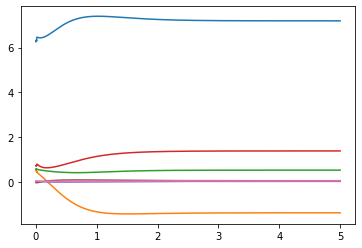

In [28]:
plt.plot(log1.sample_times(), log1.data()[0, :], log1.sample_times(), log1.data()[1, :],\
        log1.sample_times(), log1.data()[2, :], log1.sample_times(), log1.data()[3, :], \
        log1.sample_times(), log1.data()[4, :], log1.sample_times(), log1.data()[5, :], \
        log1.sample_times(), log1.data()[6, :])

In [29]:
# Max torque required
# We can enforce max torque requirements at each joint in the URDF itself
np.max(log1.data())

7.400279551252254

In [36]:
# Now we need to compute settling time
log2.data()[:, 0]

array([ 0.6097111 , -0.04402484,  0.22363931, -1.88203719,  0.01227733,
       -0.72208045,  0.05594299,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

In [60]:
# Use the same formula as before for the settling time
ts = 8/np.sqrt(Kp)[0]
print(ts)

3.4112114616897666


In [59]:
# We need to compute forces on the end-effector
G = plant.GetBodyByName("eef").body_frame()
W = plant.world_frame()
J_G = plant.CalcJacobianSpatialVelocity(plant_context, JacobianWrtVariable.kQDot, G, [0,0,0], W, W)
# We need forces in Z direction in general but at kind of force and moment can be 
# added as long as the system is statico
joint_torques = np.matmul(J_G.transpose(), np.array([0,0,-10,0,0,-5]))
print(joint_torques)
print(np.max(abs(joint_torques)))

[-2.83674977e-03 -1.00000000e+01 -3.89790754e-16 -2.22500000e+00
 -4.51319227e-16 -5.50000000e-01 -1.00000000e+01]
10.0


In [58]:
# For payload computation
# We need to compute forces on the end-effector
G = plant.GetBodyByName("eef").body_frame()
W = plant.world_frame()
plant.SetPositions(plant.GetMyContextFromRoot(context),model,
                      [0,-1.57,0,0,0,0,0])
diagram.Publish(context)

J_G = plant.CalcJacobianSpatialVelocity(plant_context, JacobianWrtVariable.kQDot, G, [0,0,0], W, W)
joint_torques = np.matmul(J_G.transpose(), np.array([0,10,0,0,0,0]))
print(joint_torques)
print(np.max(abs(joint_torques)))

[ 0.00000000e+00  0.00000000e+00 -6.99999943e-03  9.99999755e+00
 -6.99999943e-03  9.99999755e+00  0.00000000e+00]
9.9999975500001


In [33]:
# Now all that is left is to integrate these
# bottom-up mappings with auto-generation of the URDF
# and solution space computation